In [52]:
import sys
import os
import numpy as np
import dill
from cycler import cycler
%matplotlib inline
import matplotlib.pyplot as plt
root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)
from src.utilities.AttrDict import AttrDict
GEOMETRY = AttrDict()
GATE = AttrDict()
from src.configuration import t#, dt, n_x, n_z, rho_s, dx, dz
# from scipy.interpolate import interp1d, InterpolatedUnivariateSpline
from src.utilities.nearest import nearest
from src.initialisation.initialise_main import initialisation
from src.pressure import pressure
from src.stress import stress_time
from src.fatigue import fatigue

# Plotting options
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Helvetica'] + plt.rcParams['font.serif']
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['#000000'])

Specify the name of the load case and the amount of modes to consider, and initialize the model.
For new gate designs the entire notebook should be reset and re-initialized.

In [2]:
GATE.case   = 'Gate1_test'
GATE.n_modes= 16
GATE.Ly     = 1 # Overhang length
GATE.zeta   = 0.02 # Damping
GATE.cdamp  = 0 # Distributed damping
GATE.HEIGHT = 7.5
GATE.WIDTH  = 10
## Heights of horizontal stiffeners
GEOMETRY.Height  = 2.55
GEOMETRY.Height2 = 5.0
GEOMETRY.Height3 = GATE.HEIGHT
## X-coordinates of vertical stiffeners
GEOMETRY.Width  = 2.5
GEOMETRY.Width2 = 5
GEOMETRY.Width3 = 7.45
GEOMETRY.Width4 = GATE.WIDTH
## Stiffener depths
GEOMETRY.LengthHorRibs  = 0.71
GEOMETRY.LengthVertRibs = 0.71
## Supports (Left-Bottom-Right-Top)
GEOMETRY.Stiffness  = 3e11
GEOMETRY.Stiffness2 = 0
GEOMETRY.Stiffness3 = 3e11
GEOMETRY.Stiffness4 = 0
## Element thicknesses
GEOMETRY.Platethickness    = 0.05
GEOMETRY.RibThicknessHor   = 0.1
GEOMETRY.RibThicknessHor2  = 0.1
GEOMETRY.RibThicknessHor3  = 0.1
GEOMETRY.RibThicknessHor4  = 0.1
GEOMETRY.RibThicknessVert  = 0.1
GEOMETRY.RibThicknessVert2 = 0.1
GEOMETRY.RibThicknessVert3 = 0.1
GEOMETRY.RibThicknessVert4 = 0.1
GEOMETRY.RibThicknessVert5 = 0.1
GATE.GEOMETRY = GEOMETRY

GATE = initialisation(GATE, overwrite=False)

Loading existing modes...
Loaded existing frequency response function(s) and gate properties for case Gate1_test.


# Load case definition
Probability distributions are derived from historical data and condensed into discrete load cases.

First the raw data is read from the specified text files and formatted in a DataFrame. The formatted data is then stored in the 02_preprocessing folder.

Data stored in ../data/02_preprocessing/data_1971.cp.pkl


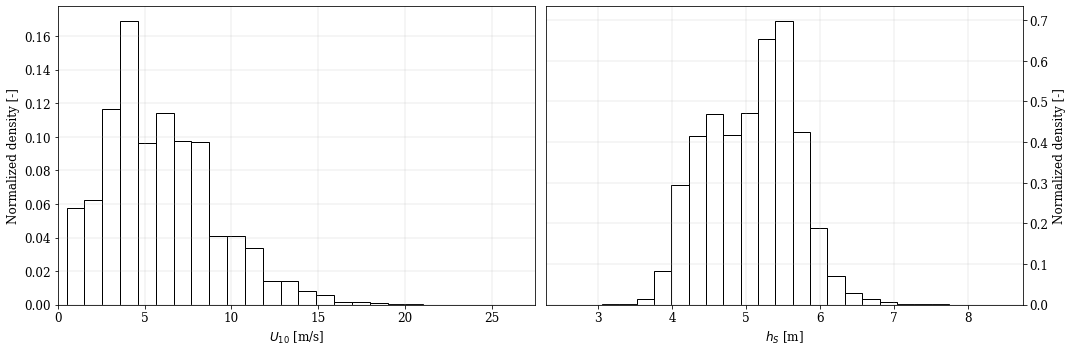

In [13]:
from src.loadcases import import_raw_data, create_pdf, binning, binfilter
fig, raw_data = import_raw_data(windfile='KNMI_20201124_hourly.txt', waterfile='20201105_007.csv', bins=25)
fig

Next, the data is pre-processed and transformed into two probability distributions which also account for climate change.

Pearsons correlation: 0.158
Integral of convoluted pdf: 1.0


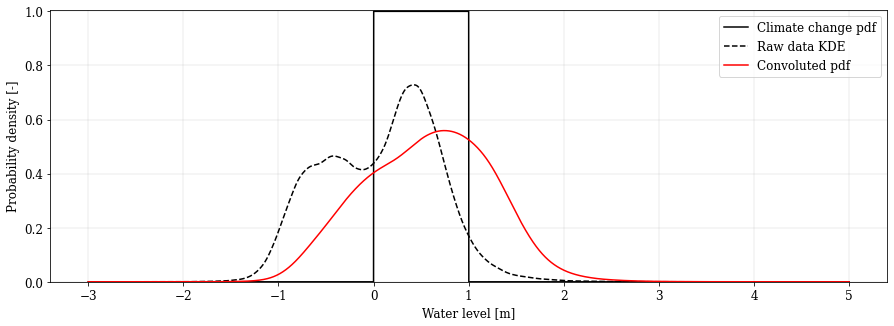

In [5]:
fig, dists = create_pdf(raw_data, rise=1, n_h=1e4, n_u=1e4, h_range=[2,10])
fig

The probability distributions are then integrated into discrete sections, whose expected values will represent the properties of the discrete load cases. The probability of occurrence is found by integrating the probability density over the area of the segment.

In [9]:
with open('../data/03_loadevents/pdfs.cp.pkl', 'rb') as file:
    dists = dill.load(file)

80 h_S-bins by 56 u-bins


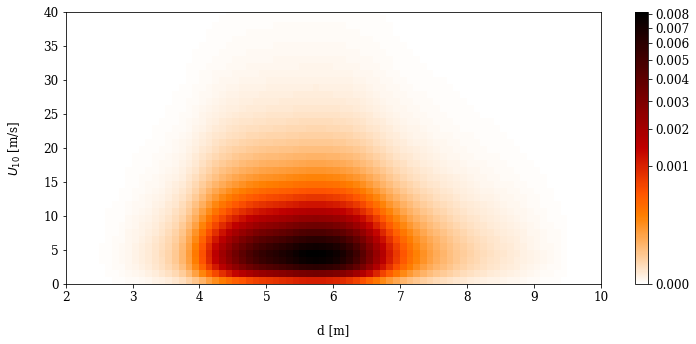

In [10]:
fig1, u_bins, h_bins, cases = binning(dists, h_res=0.1, u_res=1)
fig1

The load cases are then filtered based on their probability of occurrence and their intensity.

Starting with 4480 cases
Filtering cases with probability less than 1/10,000 years...
2066 cases left after frequency filtering
Filtering cases with h_S+2*Hm0 < h_G...
1482 cases left after Hm0 filtering
66% of bins filtered out.


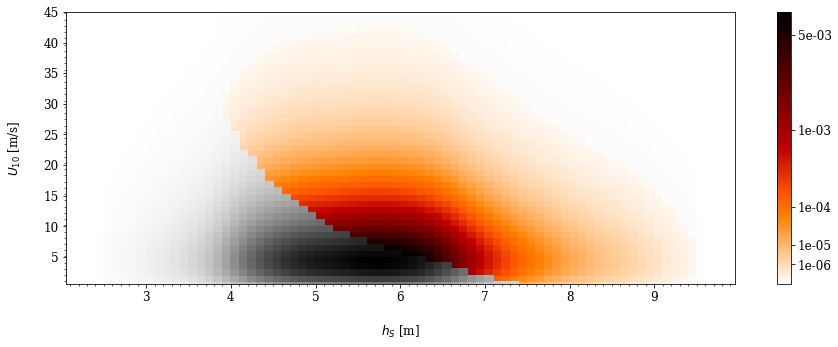

In [11]:
fig2, filtcases = binfilter(cases, GATE, freqfilter=True, intensityfilter=True)
fig2

## Discrete load case resolution
An analysis of the effect of different load case resolutions on the variance of the response.

In [38]:
# h_base = 0.1
# u_base = 1
# h_list = [0.001, 0.1, 0.5, 1, 2]
# u_list = [0.1, 0.5, 1, 2, 5, 10]

# with open('../data/08_analysis/fatigue_std_comparisons.cp.pkl', 'rb') as file:  
#     std_same, fatigue_dat = dill.load(file)

# fatigue_dict = []
# for i, h in enumerate(h_list):
#     fatigue_dict.append({'u':u_base, 'h':h, 'D':fatigue_dat[0][i]})
# for i, u in enumerate(u_list):
#     fatigue_dict.append({'u':u, 'h':h_base, 'D':fatigue_dat[1][i]})
    
# with open('../data/03_loadevents/fatigue_std_comparisons.pkl', 'wb') as file:  
#     dill.dump(fatigue_dict, file)

In [ ]:
# def discrete_variance(h_sea, h_res, u_wind, u_res, runs, coords):
#     with open('../data/03_loadevents/pdfs.cp.pkl', 'rb') as file:  
#         x_h, h_pdf, x_u, u_pdf = dill.load(file)
#     coords  = nearest(*coords)
#     if h_res==0:
#         h_values = np.ones(runs)*h_sea
#     else:
#         h_range = [h_sea-h_res/2, h_sea, h_sea+h_res/2]
#         h_slice = np.logical_and((x_h >= min(h_range)), x_h <= max(h_range))
#         h_values = np.random.choice(a=x_h[h_slice], p=h_pdf[h_slice]/np.sum(h_pdf[h_slice]), size=runs)
#     if u_res==0:
#         u_values = np.ones(runs)*u_wind
#     else:
#         u_range = [u_wind-u_res/2, u_wind, u_wind+u_res/2]
#         u_slice = np.logical_and((x_u >= min(u_range)), x_u <= max(u_range))
#         u_values = np.random.choice(a=x_u[u_slice], p=u_pdf[u_slice]/np.sum(u_pdf[u_slice]), size=runs)
    
#     d_list = np.zeros(runs)
#     for i, (rand_u, rand_h) in enumerate(zip(u_values, h_values)):
#         f, pqs_f, p_imp_t, _, _ = pressure(rand_u, rand_h)
#         _, response_t = stress_time(f, pqs_f, p_imp_t, coords)
#         d_list[i] = fatigue(response_t, cat=100)
#     return d_list

# def sensitivity_discretisation(h_sea, h_res_list, u_wind, u_res_list, runs=100, coords=(5,1,7.5), overwrite=False):
#     filename = '../data/03_loadevents/%s_fatigue_std_comparisons.pkl'%runs
#     if os.path.exists(filename) and (overwrite==False):
#         with open(filename, 'rb') as file:  
#             d_ref, h_list_d_old, u_list_d_old, h_res_list_old, u_res_list_old = dill.load(file)
#         new_h_res = list(set(h_res_list) - set(h_res_list_old))
#         new_u_res = list(set(u_res_list) - set(u_res_list_old))
#         print('Using old calculations..')
#     else:
#         new_h_res = h_res_list
#         new_u_res = u_res_list
#         h_res_list_old = []
#         u_res_list_old = []
#         h_list_d_old = np.zeros(0)
#         u_list_d_old = np.zeros(0)
#         print('Starting new calculation...')
#         d_ref = discrete_variance(h_sea, 0, u_wind, 0, runs, coords)
#     h_list_d = np.zeros([len(new_h_res), runs])
#     for i, h_res in enumerate(new_h_res):
#         h_list_d[i] = discrete_variance(h_sea, h_res, u_wind, 0, runs, coords)
#     print('Finished water level sensitivity.')
#     u_list_d = np.zeros([len(new_u_res), runs])
#     for i, u_res in enumerate(new_u_res):
#         u_list_d[i] = discrete_variance(h_sea, 0, u_wind, u_res, runs, coords)
#     print('Finished wind velocity sensitivity.')
#     h_list_d = np.concatenate((h_list_d, h_list_d_old), axis=0)
#     u_list_d = np.concatenate((u_list_d, u_list_d_old), axis=0)
#     h_res_list = new_h_res+h_res_list_old
#     u_res_list = new_u_res+u_res_list_old
#     with open(filename, 'wb') as file:  
#         dill.dump([d_ref, h_list_d, u_list_d, h_res_list, u_res_list], file)
#     std_same = np.std(d_ref)
#     max_std = 0
#     xlabels = ['res$_{h_S}$ [m]', 'res$_{U_{10}}$ [m/s]']
#     fig, axes = plt.subplots(1,2)
#     for i, (ax, results, reslist) in enumerate(zip(axes, [h_list_d, u_list_d], [h_res_list,u_res_list])):
#         stds = [np.std(data) for data in results]
#         ax.plot(reslist, stds, color='blue', label='%s randomly picked values'%(runs))
#         ax.hlines(std_same, reslist[0], reslist[-1], ls='--', label='%s identical repetitions'%(runs))
#         ax.set_xlim(reslist[0], reslist[-1])
#         if np.max(stds)> max_std:
#             max_std = np.max(stds)
#         ax.set_xscale('log')
#         ax.set_ylim(0, max_std)
#         ax.set_xlabel(xlabels[i])
#         ax.set_ylabel('$STD_D$ [-]')
#         ax.ticklabel_format(axis='y',style='sci', scilimits=(0,0))
#         ax.legend(loc='upper left')
#     plt.close(fig)
#     return fig

from src.loadcases import sensitivity_discretisation

h_res_list = [0.001, 0.1, 0.5, 1, 2]
u_res_list = [0.1, 0.5, 1, 2, 5, 10]
h_sea = 6.5
u_wind = 30
fig = sensitivity_discretisation(h_sea, h_res_list, u_wind, u_res_list, runs=100, coords=(5,1,7.5), overwrite=False)
fig

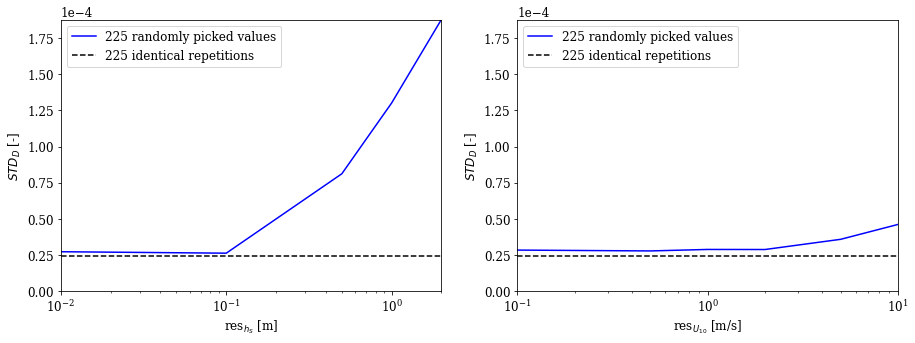

# Fatigue over gate surface
Calculating the fatigue due to a given load event at every point on the gate's surface to identify the distribution and critical coordinates.

In [3]:
from src.full_gate_fatigue import fatigue_gate, plot_fatigue_gate, modalstresscontribution, modalfatiguecontribution

u_wind = 20
h_sea = 7
ID=GATE.case
D, modeshare = fatigue_gate(u_wind, h_sea, cat=100, ID=GATE.case, overwrite=False)

Loading old fatigue calculations...


The next cell plots the fatigue across the gate for one or multiple gate designs, and determines the coordinate where the most fatigue occurs.

Maximum fatigue in Gate1_test is 0.00036 and occurs at: [5.   0.71 7.5 ]
Maximum fatigue in Gate1_test: 0.00036
Maximum fatigue in Gate1_1mode: 8e-05


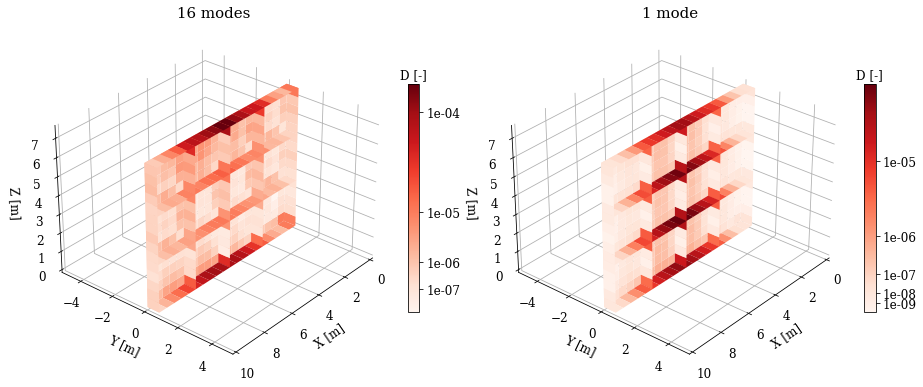

In [5]:
with open('../data/08_analysis/full_gate_fatigue/gatefatigue_('+str(u_wind)+','+str(h_sea)+'_'+str(ID)+').cp.pkl', 'rb') as f:
    damage_gate, modeshare = dill.load(f)
max_coords = GATE.coords[np.argmax(damage_gate)]
print("Maximum fatigue in %s is %s and occurs at: %s"%(GATE.case, round(np.max(damage_gate),5), max_coords))
plot_fatigue_gate(['Gate1_test', 'Gate1_1mode'], ['16 modes', '1 mode'], u_wind, h_sea)

## Mode contribution
Various ways of determining the relative importance of different modes on the total response across the gate.

The contribution of the different modes to the total stress in the gate is plotted. The leftmost plot shows the distribution across all gate coordinates and the rightmost one the distribution at the critical coordinate.

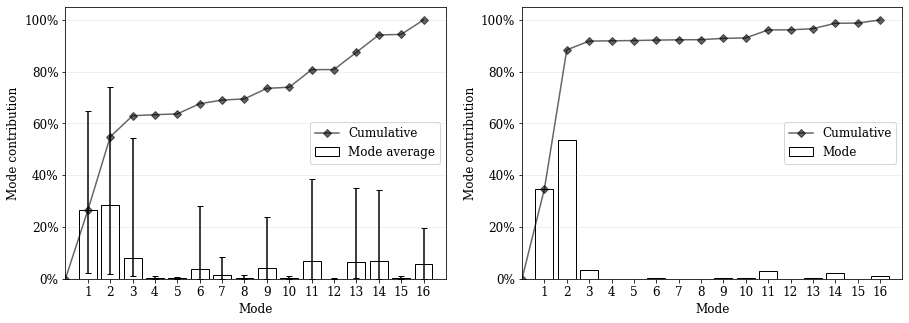

In [8]:
modalstresscontribution(modeshare, max_coords)

This plot shows the effect on the fatigue when a given mode is removed from the response. A value of 60% means that 60% of the fatigue is lost (does not add up to 100%).

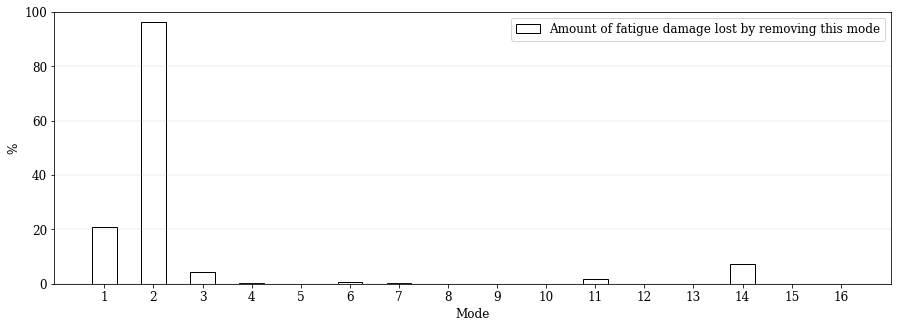

In [10]:
fig, shares = modalfatiguecontribution(u_wind, h_sea, max_coords, cat=100, save=False)
fig

This plot shows the combined contribution of a given set of modes to the total stress at every coordinate.

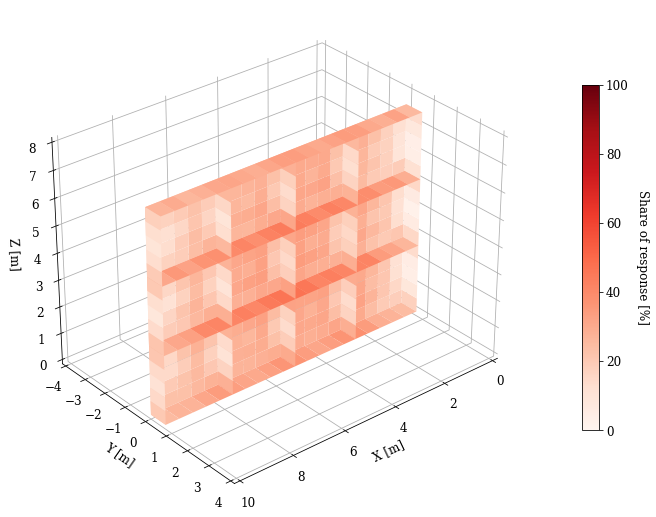

In [11]:
from src.full_gate_fatigue import plot_modeshare_gate
modes = [1]
plot_modeshare_gate(modes, modeshare)

# Full lifetime fatigue analysis
This section uses the load cases from Section 1 to compute a probabilistic estimate of the lifetime fatigue

First, define the coordinates to evaluate and the name under which the results should be stored.

In [3]:
coords = nearest(5,1,7.5)
version = GATE.case
print(coords, version)

(5.0, 0.71, 7.5) Gate1_test


The following function evaluates the fatigue for all previously derived load cases at the coordinate specified above, and performs a probabilistic fatigue lifetime simulation (can take an hour for new cases). If the version name has already been used before, the existing data will be loaded instead.

Analyzing coordinate (5.0, 0.71, 7.5)
Using existing runs from ../data/07_fatigue/Gate1_test/Gate1_test.pkl
N load cases already exist.
Using old simulations from ../data/07_fatigue/Gate1_test/1000_lifetimes_vGate1_test.pkl


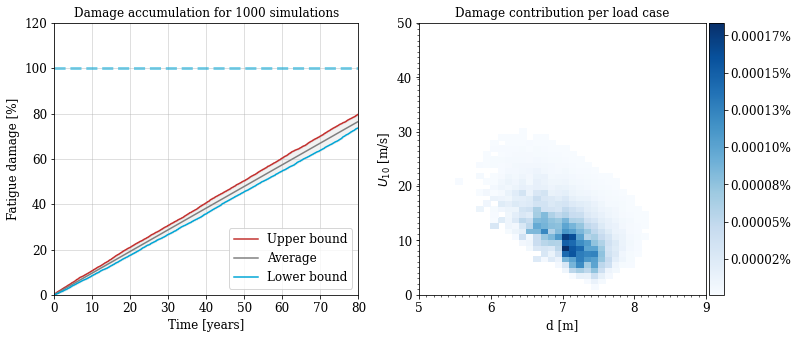

In [4]:
from src.lifetime import generate_fatigue, simulations

damage_list = generate_fatigue(coords, version, N=1e6)
fig, D_expected, totals, [maxes,means,mins] = simulations(runs=1000, version=version, average_only=False)